# Scrape venues

In [20]:
import requests
import pandas as pd

In [67]:
# Define region
sw_long = 52.022926
sw_lat = 4.231183

ne_long = 52.062310
ne_lat = 4.313249

# define n cells per lat/long
n_cells = 20

In [68]:
# Read my foursquare api key
with open('../keys/foursquare_key.txt', 'r') as file:
    api_key = file.read().replace('\n', '')

In [69]:
URL = 'https://api.foursquare.com/v3/places/search?categories={}&ne={}&sw={}&limit=50'
headers = {
    "accept": "application/json",
    "Authorization": api_key
}

In [70]:
def read_foursquare_codes(path):
    df = pd.read_excel(path) # can also index sheet by name or fetch all sheets
    df = df[df['Included']=='y']
    codes = df['Code'].tolist()
    
    string_ints = [str(int) for int in codes]
    str_of_ints = ",".join(string_ints)
    
    return(str_of_ints)

In [71]:
path = 'codes_categories_foursquare/education_codes.xlsx'
#categories = read_foursquare_codes(path)
#categories = '11000' # Business and Professional Services
#categories = '13000' # Dining and Drinking
categories = '17000' # retails


categories

'17000'

In [72]:
coordinates = []
delta_x = (ne_long - sw_long)/n_cells
delta_y = (ne_lat - sw_lat)/n_cells

venues = []
limit_50_reached = False

counter = 0
for y in range(n_cells):
    if (limit_50_reached == False):
        for x in range(n_cells):
            if (limit_50_reached == False):
                counter += 1
                sw_x = sw_long + x*delta_x
                sw_y = sw_lat + y*delta_y
                ne_x = sw_long + (x+1)*delta_x
                ne_y = sw_lat + (y+1)*delta_y

                north_east = str(ne_x) + ',' + str(ne_y)
                south_west = str(sw_x) + ',' + str(sw_y) 

                url = URL.format(categories, north_east, south_west)

                response = requests.get(url, headers=headers)

                data = response.json()['results']

                if (len(data) > 0):
                    if (len(data)==50):
                        print('Limit of 50 results reached! Make grids cells smaller.')
                        limit_50_reached = True
                        break
                    else:
                        venues = venues + data

                print('Proportion scraped:', round(counter/(n_cells**2), 2)*100, '%')
print('done')

Proportion scraped: 0.0 %
Proportion scraped: 1.0 %
Proportion scraped: 1.0 %
Proportion scraped: 1.0 %
Proportion scraped: 1.0 %
Proportion scraped: 1.0 %
Proportion scraped: 2.0 %
Proportion scraped: 2.0 %
Proportion scraped: 2.0 %
Proportion scraped: 3.0 %
Proportion scraped: 3.0 %
Proportion scraped: 3.0 %
Proportion scraped: 3.0 %
Proportion scraped: 4.0 %
Proportion scraped: 4.0 %
Proportion scraped: 4.0 %
Proportion scraped: 4.0 %
Proportion scraped: 4.0 %
Proportion scraped: 5.0 %
Proportion scraped: 5.0 %
Proportion scraped: 5.0 %
Proportion scraped: 6.0 %
Proportion scraped: 6.0 %
Proportion scraped: 6.0 %
Proportion scraped: 6.0 %
Proportion scraped: 7.000000000000001 %
Proportion scraped: 7.000000000000001 %
Proportion scraped: 7.000000000000001 %
Proportion scraped: 7.000000000000001 %
Proportion scraped: 7.000000000000001 %
Proportion scraped: 8.0 %
Proportion scraped: 8.0 %
Proportion scraped: 8.0 %
Proportion scraped: 9.0 %
Proportion scraped: 9.0 %
Proportion scraped: 

Proportion scraped: 72.0 %
Proportion scraped: 72.0 %
Proportion scraped: 72.0 %
Proportion scraped: 73.0 %
Proportion scraped: 73.0 %
Proportion scraped: 73.0 %
Proportion scraped: 73.0 %
Proportion scraped: 74.0 %
Proportion scraped: 74.0 %
Proportion scraped: 74.0 %
Proportion scraped: 74.0 %
Proportion scraped: 75.0 %
Proportion scraped: 75.0 %
Proportion scraped: 75.0 %
Proportion scraped: 76.0 %
Proportion scraped: 76.0 %
Proportion scraped: 76.0 %
Proportion scraped: 76.0 %
Proportion scraped: 77.0 %
Proportion scraped: 77.0 %
Proportion scraped: 77.0 %
Proportion scraped: 77.0 %
Proportion scraped: 78.0 %
Proportion scraped: 78.0 %
Proportion scraped: 78.0 %
Proportion scraped: 78.0 %
Proportion scraped: 79.0 %
Proportion scraped: 79.0 %
Proportion scraped: 79.0 %
Proportion scraped: 79.0 %
Proportion scraped: 80.0 %
Proportion scraped: 80.0 %
Proportion scraped: 80.0 %
Proportion scraped: 80.0 %
Proportion scraped: 81.0 %
Proportion scraped: 81.0 %
Proportion scraped: 81.0 %
P

In [73]:
df = pd.json_normalize(venues,
                       max_level=2,
                       record_path=['categories'],
                       meta=['fsq_id',
                             'name',
                             ['geocodes', 'main', 'latitude'],
                             ['geocodes', 'main', 'longitude'],
                             ['location', 'address'],
                             ['location', 'postcode']],
                       errors='ignore',
                       record_prefix='categories-'
                      )
df = df.drop(columns=['categories-icon.prefix', 'categories-icon.suffix', 'categories-id'])

# Rename columns
df = df.rename(columns={'location.postcode': 'PC6'})
df['PC6'] = df['PC6'].str.replace(" ", "")

df = df.rename(columns={'geocodes.main.latitude': 'latitude'})
df = df.rename(columns={'geocodes.main.longitude': 'longitude'})
df = df.rename(columns={'location.address': 'address'})
df = df.rename(columns={'categories-name': 'category'})

# Remove duplicates that might arise from the grid search
df = df.drop_duplicates()

# Filter venues in DHZW

In [74]:
import geopandas
from shapely.geometry import Point

In [75]:
# Import polygon extent
df_DHZW = geopandas.read_file("DHZW_merged/DHZW_neighbs_shapefi_Project.shp")
# Convert the polygon CRS to the one of Foursquare
df_DHZW = df_DHZW.to_crs("EPSG:4326")

# Add a column to flag the venues in the area
df['withinQ'] = ""

withinQlist = []
for lon,lat in zip(df.longitude, df.latitude):
    pt = Point(lon, lat)
    withinQ = pt.within(df_DHZW['geometry'].values[0])
    withinQlist.append(withinQ)

# update values in the that column, values: True/False
df['withinQ'] = withinQlist
result_df = df[df.withinQ==True]
result_df = result_df.drop(columns=['withinQ'])

## Plot venues

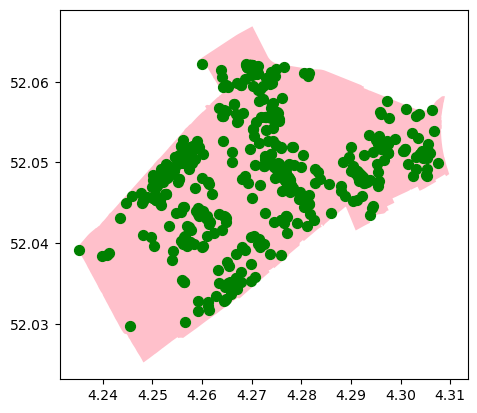

In [76]:
ax1 = df_DHZW.plot(color='pink')
ax1.scatter(result_df.longitude, result_df.latitude, s=50, color='green')

In [77]:
result_df

,category,fsq_id,name,latitude,longitude,address,PC6
14,Auction House,2fc06d5effb14f7d92e9a46e,Veiling Bloemen Online,52.0392,4.235123,NaN,NaN
130,Retail,528f3d9611d2905981d9b22f,070 Outlet Store,52.038549,4.240766,NaN,NaN
131,Sporting Goods Retail,4f2534e2e4b0d10db1404938,Ooms Sport De Uithof,52.03837,4.239861,Jaap Edenweg 10,2544NL
132,Retail,100ca3592b5d44c583347c72,Ooms Retail Groep B.V.,52.038812,4.241207,Jaap Edenweg 10,2544NL
170,Retail,b7036ffa23ed4887810c9085,Damara Kids,52.029745,4.245542,Abdis Eustachiastraat 15,2544NH
...,...,...,...,...,...,...,...
1053,Retail,7b484035593b4b0a09b2e107,Interstar Trading BV,52.051126,4.305914,Heeswijkplein 105,2531HG
1054,Vintage and Thrift Store,da733693d9c14ff75707dfaa,Kringloop Moerwijk,52.051475,4.305543,Heeswijkplein 132,2531HH
1055,Car Dealership,d6763c25458e48ba61e6c274,Ganda Export Cars,52.05231,4.305418,Schoonhetenstraat 43,2531RK
1056,Automotive Retail,517e51fce4b0a48296a35841,Garage De Haan,52.053893,4.306675,NaN,NaN


## PC6 reconstruction

In [78]:
# Read geometry of PC6 in the area
df_PC6 = geopandas.read_file("DHZW_PC6_shapefile/DHZW_PC6_shapefile.shp")

# Apply the Foursquare CRS to the area
df_PC6_crs = df_PC6.to_crs("EPSG:4326")

In [79]:
# Calculate geometry point for the venues from their longitude and latitude
df = geopandas.GeoDataFrame(result_df, geometry=geopandas.points_from_xy(result_df.longitude, result_df.latitude))

# Remove the PC6 from Foursquare, to be overridden
df = df.drop(columns=['PC6'])

C:\Users\6997619\Anaconda3\envs\dhzw_env\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [80]:
# Spatial join
df = geopandas.sjoin(df, df_PC6_crs)

C:\Users\6997619\AppData\Local\Temp\ipykernel_5168\2707079593.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = geopandas.sjoin(df, df_PC6_crs)


In [81]:
df = df.drop(columns=['index_right', 'geometry'])
df.to_csv('data/retails.csv', index=False)

In [82]:
df

,category,fsq_id,name,latitude,longitude,address,PC6
14,Auction House,2fc06d5effb14f7d92e9a46e,Veiling Bloemen Online,52.0392,4.235123,NaN,2544NG
130,Retail,528f3d9611d2905981d9b22f,070 Outlet Store,52.038549,4.240766,NaN,2544NL
131,Sporting Goods Retail,4f2534e2e4b0d10db1404938,Ooms Sport De Uithof,52.03837,4.239861,Jaap Edenweg 10,2544NL
132,Retail,100ca3592b5d44c583347c72,Ooms Retail Groep B.V.,52.038812,4.241207,Jaap Edenweg 10,2544NL
170,Retail,b7036ffa23ed4887810c9085,Damara Kids,52.029745,4.245542,Abdis Eustachiastraat 15,2544NH
...,...,...,...,...,...,...,...
1053,Retail,7b484035593b4b0a09b2e107,Interstar Trading BV,52.051126,4.305914,Heeswijkplein 105,2531HG
1054,Vintage and Thrift Store,da733693d9c14ff75707dfaa,Kringloop Moerwijk,52.051475,4.305543,Heeswijkplein 132,2531HH
1055,Car Dealership,d6763c25458e48ba61e6c274,Ganda Export Cars,52.05231,4.305418,Schoonhetenstraat 43,2531RK
1056,Automotive Retail,517e51fce4b0a48296a35841,Garage De Haan,52.053893,4.306675,NaN,2532CP
